# Where the Bugs are

Every time a bug is fixed, developers leave a trace – in the _version database_ when they commit the fix, or in the _bug database_ when they close the bug. In this chapter, we learn how to _mine these repositories_ for past changes and bugs, and how to _map_ them to individual modules and functions, highlighting those project components that have seen most changes and fixes over time.

In [1]:
from bookutils import YouTubeVideo
YouTubeVideo("Aifq0JOc1Jc")

**Prerequisites**

* You should have read [the chapter on tracking bugs](Tracking.ipynb).

In [2]:
import bookutils.setup

In [3]:
import Tracking

## Synopsis
To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.ChangeCounter import <identifier>
```

and then make use of the following features.

**Note**: The examples in this section only work after the rest of the cells have been executed.


This chapter provides two classes `ChangeCounter` and `FineChangeCounter` that allow mining and visualizing the distribution of changes in a given `git` repository.

`ChangeCounter` is initialized as

```python
change_counter = ChangeCounter(repository)
```
where `repository` is either 

* a _directory_ containing a `git` clone (i.e., it contains a `.git` directory)
* the URL of a `git` repository.

Additional arguments are being passed to the underlying `Repository` class from the [PyDriller](https://pydriller.readthedocs.io/) Python package. A `filter` keyword argument, if given, is a predicate that takes a modification (from PyDriller) and returns True if it should be included.

In a change counter, all elements in the repository are represented as _nodes_ – tuples $(f_1, f_2, ..., f_n)$ that denote a _hierarchy_: Each $f_i$ is a directory holding $f_{i+1}$, with $f_n$ being the actual file.

A `change_counter` provides a number of attributes. `changes` is a mapping of nodes to the number of changes in that node:

In [107]:
change_counter.changes.get(('README.md',), None)

20

The `messages` attribute holds all commit messages related to that node:

In [108]:
change_counter.messages.get(('README.md',), None)

['Doc update',
 'Doc update',
 'Doc update',
 'Doc update',
 'Fix: corrected rule for rendered notebooks (#24)\nNew: strip out any <iframe> tags\nNew: when rendering .md files, replace videos by proper image',
 'Doc update',
 'Doc update',
 'New: show badges at top of GitHub project page',
 'More badges',
 'Fix: bad links in CI badges',
 'New: prefer Unicode arrows over LaTeX ones',
 'Updated README.md',
 'Update',
 'Doc update',
 'Doc update',
 'Doc update',
 'Doc update',
 'Updated README',
 'Doc update',
 'Doc update']

The `sizes` attribute holds the (last) size of the respective element:

In [109]:
change_counter.sizes.get(('README.md',), None)

4728

`FineChangeCounter` acts like `ChangeCounter`, but also retrieves statistics for elements _within_ the respective files; it has been tested for C, Python, and Jupyter Notebooks and should provide sufficient results for programming languages with similar syntax.

The `map()` method of `ChangeCounter` and `FineChangeCounter` produces an interactive tree map that allows exploring the elements of a repository. The redder (darker) a rectangle, the more changes it has seen; the larger a rectangle, the larger its size in bytes.

In [110]:
fine_change_counter.map()

The included classes offer several methods that can be overridden in subclasses to customize what to mine and how to visualize it. See the chapter for details.

Here are all the classes defined in this chapter:

In [111]:
# ignore
from ClassDiagram import display_class_hierarchy

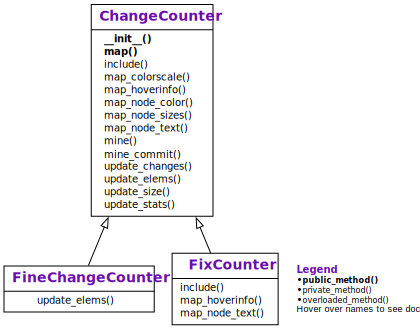

In [112]:
# ignore
display_class_hierarchy([FineChangeCounter, FixCounter],
                        public_methods=[
                            ChangeCounter.__init__,
                            ChangeCounter.map
                        ],
                        project='debuggingbook')

## Mining Change Histories

The history of any software project is a history of change. Any nontrivial project thus comes with a _version database_ to organize and track changes; and possibly also with an [issue database](Tracking.ipynb) to organize and track issues.

Over time, these databases hold plenty of information about the project: _Who changed what, when, and why?_ This information can be _mined_ from existing databases and _analyzed_ to answer questions such as

* Which parts in my project were most frequently or recently changed?
* How many files does the average change touch?
* Where in my project were the most bugs fixed?

To answer such questions, we can _mine_ change and bug histories for past changes and fixes. This involves digging through version databases such as `git` and [issue trackers such as RedMine or Bugzilla](Tracking.ipynb) and extracting all their information. Fortunately for us, there is ready-made infrastructure for some of this. 

## Mining with PyDriller

[PyDriller](https://pydriller.readthedocs.io/) is a Python package for mining change histories. Its `Repository` class takes a `git` version repository and allows accessing all the individual changes ("modifications"), together with committers, affected files, commit messages, and more.

In [4]:
from pydriller import Repository  # https://pydriller.readthedocs.io/

In [5]:
from pydriller.domain.commit import Commit

In [6]:
from pydriller.domain.commit import ModifiedFile

To use `Repository`, we need to pass it 
* the URL of a `git` repository; or
* the directory name where a cloned `git` repository can be found.

In general, cloning a `git` repository locally (with `git clone URL`) and then analyzing it locally will be faster and require less network resources.

Let us apply `Repository` on the repository of this book. The function `current_repo()` returns the directory in which a `.git` subdirectory is stored – that is, the root of a cloned `git` repository.

In [7]:
import os

In [8]:
# ignore
from typing import Callable, Optional, Type, Tuple, Any
from typing import Dict, Union, Set, List

In [9]:
def current_repo() -> Optional[str]:
    path = os.getcwd()
    while True:
        if os.path.exists(os.path.join(path, '.git')):
            return os.path.normpath(path)

        # Go one level up
        new_path = os.path.normpath(os.path.join(path, '..'))
        if new_path != path:
            path = new_path
        else:
            return None

    return None

In [10]:
current_repo()

'/Users/zeller/Projects/debuggingbook'

This gives us a repository miner for the book:

In [11]:
from datetime import datetime

In [12]:
book_miner = Repository(current_repo(), to=datetime(2020, 10, 1))

The `to` argument limits the range of time we want to look at.

You can also specify a URL instead, but this will access the repository via the network and generally be much slower.

In [13]:
DEBUGGINGBOOK_REMOTE_REPO = 'https://github.com/uds-se/debuggingbook.git'
# book_miner = Repository(DEBUGGINGBOOK_REMOTE_REPO)

In [14]:
# ignore
if 'CI' in os.environ:
    # The CI git clone is shallow, so access full repo remotely
    book_miner = Repository(DEBUGGINGBOOK_REMOTE_REPO,
                            to=datetime(2020, 10, 1))

`traverse_commits()` is a generator that returns one commit after another. Let us fetch the very first commit made to the book:

In [15]:
book_commits = book_miner.traverse_commits()
book_first_commit = next(book_commits)

Each commit has a number of attributes telling us more about the commit.

In [16]:
[attr for attr in dir(book_first_commit) if not attr.startswith('_')]

['author',
 'author_date',
 'author_timezone',
 'branches',
 'co_authors',
 'committer',
 'committer_date',
 'committer_timezone',
 'deletions',
 'dmm_unit_complexity',
 'dmm_unit_interfacing',
 'dmm_unit_size',
 'files',
 'hash',
 'in_main_branch',
 'insertions',
 'lines',
 'merge',
 'modified_files',
 'msg',
 'parents',
 'project_name',
 'project_path']

For instance, the `msg` attribute lets us know about the commit message:

In [17]:
book_first_commit.msg

'first commit'

whereas the `author` attribute gets us the name and email of the person who made the commit:

In [18]:
[attr for attr in dir(book_first_commit.author) if not attr.startswith('_')]

['email', 'name']

In [19]:
book_first_commit.author.name, book_first_commit.author.email

('Andreas Zeller', 'zeller@cispa.saarland')

A commit consists of multiple _modifications_ to possibly multiple files. The commit `modified_files` attribute returns a list of modifications.

In [20]:
book_first_commit.modified_files

For each modification, we can retrieve the files involved as well as several statistics:

In [21]:
[attr for attr in dir(book_first_commit.modified_files[0]) if not attr.startswith('_')]

['added_lines',
 'change_type',
 'changed_methods',
 'complexity',
 'content',
 'content_before',
 'deleted_lines',
 'diff',
 'diff_parsed',
 'filename',
 'language_supported',
 'methods',
 'methods_before',
 'new_path',
 'nloc',
 'old_path',
 'source_code',
 'source_code_before',
 'token_count']

Let us see which file was created with this modification:

In [22]:
book_first_commit.modified_files[0].new_path

'README.md'

The `content` attribute holds the entire file contents after the modification.

In [23]:
print(book_first_commit.modified_files[0].content)

b'# debuggingbook\n'


We see that the `debuggingbook` project started with a very simple commit, namely the addition of an (almost empty) `README.md` file.

The attribute `content_before` holds the previous source code. We see that it is `None` – the file was just created.

In [24]:
print(book_first_commit.modified_files[0].content_before)

None


Let us have a look at the _second_ commit. We see that it is much more substantial already.

In [25]:
book_second_commit = next(book_commits)

In [26]:
[m.new_path for m in book_second_commit.modified_files]

['Chapters.makefile',
 'LICENSE.md',
 'Makefile',
 'README.md',
 'debuggingbook.bib',
 'ipypublish',
 'ipypublish_plugins',
 'notebooks/.ipynb_checkpoints/index-checkpoint.ipynb',
 'notebooks/index.ipynb',
 'utils']

We fetch the modification for the `README.md` file:

In [27]:
readme_modification = [m for m in book_second_commit.modified_files if m.new_path == 'README.md'][0]

The `content_before` attribute holds the previous version (which we already have seen):

In [28]:
print(str(readme_modification.content_before, 'utf8'))

# debuggingbook



The `content` attribute holds the new version – now a complete "README" file. (Compare this first version to the [current README text](index.ipynb).)

In [29]:
print(str(readme_modification.content[:400], 'utf8'))


# About this Book

__Welcome to "The Debugging Book"!__ 

Software has bugs, and finding bugs can involve lots of effort.  This book addresses this problem by _automating_ software debugging, specifically by _locating errors and their causes automatically_.  Recent years have seen the development of novel techniques that lead to dramatic improvements in test generation and software testing.  They


The `diff` attribute holds the differences between the old and the new version.

In [30]:
print(readme_modification.diff[:100])

@@ -1 +1,157 @@
-# debuggingbook
+
+# About this Book
+
+__Welcome to "The Debugging Book"!__ 
+
+So


The `diff_parsed` attribute even lists added and deleted lines:

In [31]:
readme_modification.diff_parsed['added'][:10]

[(1, ''),
 (2, '# About this Book'),
 (3, ''),
 (4, '__Welcome to "The Debugging Book"!__'),
 (5, ''),
 (6,
  'Software has bugs, and finding bugs can involve lots of effort.  This book addresses this problem by _automating_ software debugging, specifically by _locating errors and their causes automatically_.  Recent years have seen the development of novel techniques that lead to dramatic improvements in test generation and software testing.  They now are mature enough to be assembled in a book – even with executable code.'),
 (7, ''),
 (8, ''),
 (9, ''),
 (10, '## A Textbook for Paper, Screen, and Keyboard')]

With all this information, we can track all commits and modifications and establish statistics over which files were changed (and possibly even fixed) most. This is what we will do in the next section.

In [32]:
# ignore
del book_miner  # Save a bit of memory

## Counting Changes

We start with a simple `ChangeCounter` class that, given a repository, counts for each file how frequently it was changed.

We represent file names as _nodes_ – a tuple $(f_1, f_2, ..., f_n)$ that denotes a _hierarchy_: Each $f_i$ is a directory holding $f_{i+1}$, with $f_n$ being the actual file. Here is what this notebook looks as a node:

In [33]:
tuple('debuggingbook/notebooks/ChangeCounter.ipynb'.split('/'))

('debuggingbook', 'notebooks', 'ChangeCounter.ipynb')

In [34]:
Node = Tuple

The constructor takes the repository to be analyzed and sets the internal counters.

In [35]:
from collections import defaultdict

In [36]:
import warnings

In [37]:
from git.exc import GitCommandError  # type: ignore

In [38]:
class ChangeCounter:
    """Count the number of changes for a repository."""

    def __init__(self, repo: str, *, 
                 filter: Optional[Callable[[Commit], bool]] = None, 
                 log: bool = False, 
                 **kwargs: Any) -> None:
        """
        Constructor.
        `repo` is a git repository (as URL or directory).
        `filter` is a predicate that takes a modification and returns True 
        if it should be considered (default: consider all).
        `log` turns on logging if set.
        `kwargs` are passed to the `Repository()` constructor.
        """
        self.repo = repo
        self.log = log

        if filter is None:
            def filter(m: ModifiedFile) -> bool:
                return True
        assert filter is not None

        self.filter = filter

        # A node is an tuple (f_1, f_2, f_3, ..., f_n) denoting
        # a folder f_1 holding a folder f_2 ... holding a file f_n.

        # Mapping node -> #of changes
        self.changes: Dict[Node, int] = defaultdict(int)

        # Mapping node -> list of commit messages
        self.messages: Dict[Node, List[str]] = defaultdict(list)

        # Mapping node -> last size seen
        self.sizes: Dict[Node, Union[int, float]] = {}

        self.mine(**kwargs)

The method `mine()` does all the heavy lifting of mining. It retrieves all commits and all modifications from the repository, passing the modifications through the `update_stats()` method.

In [39]:
class ChangeCounter(ChangeCounter):
    def mine(self, **kwargs: Any) -> None:
        """Gather data from repository. To be extended in subclasses."""
        miner = Repository(self.repo, **kwargs)

        for commit in miner.traverse_commits():
            try:
                self.mine_commit(commit)
            except GitCommandError as err:
                # Warn about failing git commands, but continue
                warnings.warn("Cannot mine commit " + repr(commit.hash) + '\n' + str(err))
            except (ValueError, TypeError) as err:
                warnings.warn("Cannot mine commit " + repr(commit.hash) + '\n' + str(err))
                raise err

    def mine_commit(self, commit: Commit) -> None:
        for m in commit.modified_files:
            m.committer = commit.committer
            m.committer_date = commit.committer_date
            m.msg = commit.msg

            if self.include(m):
                self.update_stats(m)

The `include()` method allows filtering modifications. For simplicity, we copy the most relevant attributes of the commit over to the modification, such that the filter can access them, too.

In [40]:
class ChangeCounter(ChangeCounter):
    def include(self, m: ModifiedFile) -> bool:
        """
        Return True if the modification `m` should be included
        (default: the `filter` predicate given to the constructor).
        To be overloaded in subclasses.
        """
        return self.filter(m)

For each such node, `update_stats()` then invokes `update_size()`, `update_changes()`, and `update_elems()`.

In [41]:
class ChangeCounter(ChangeCounter):
    def update_stats(self, m: ModifiedFile) -> None:
        """
        Update counters with modification `m`.
        Can be extended in subclasses.
        """
        if not m.new_path:
            return

        node = tuple(m.new_path.split('/'))

        self.update_size(node, len(m.content) if m.content else 0)
        self.update_changes(node, m.msg)

        self.update_elems(node, m)

`update_size()` simply saves the last size of the item being modified. Since we progress from first to last commit, this reflects the size of the newest version.

In [42]:
class ChangeCounter(ChangeCounter):
    def update_size(self, node: Tuple, size: int) -> None:
        """
        Update counters for `node` with `size`.
        Can be extended in subclasses.
        """
        self.sizes[node] = size

`update_changes()` increases the counter `changes` for the given node `node`, and adds the current commit message `commit_msg` to its list. This makes

* `size` a mapping of nodes to their size
* `changes` a mapping of nodes to the number of changes they have seen
* `commit_msg` a mapping of nodes to the list of commit messages that have affected them.

In [43]:
class ChangeCounter(ChangeCounter):
    def update_changes(self, node: Tuple, commit_msg: str) -> None:
        """
        Update stats for `node` changed with `commit_msg`.
        Can be extended in subclasses.
        """
        self.changes[node] += 1

        self.messages[node].append(commit_msg)

The `update_elems()` method is reserved for later use, when we go and count fine-grained changes.

In [44]:
class ChangeCounter(ChangeCounter):
    def update_elems(self, node: Tuple, m: ModifiedFile) -> None:
        """
        Update counters for subelements of `node` with modification `m`.
        To be defined in subclasses.
        """
        pass

Let us put `ChangeCounter` to action – on the current (debuggingbook) repository.

In [45]:
DEBUGGINGBOOK_REPO = current_repo()

In [46]:
DEBUGGINGBOOK_REPO

'/Users/zeller/Projects/debuggingbook'

The function `debuggingbook_change_counter` instantiates a `ChangeCounter` class (or any subclass) with the `debuggingbook` repository, mining all the counters as listed above. Since mining _all_ history takes quite some time, its parameter `start_date` allows setting a starting date (default: March 1, 2021); changes before that date will be ignored.

In [47]:
DEBUGGINGBOOK_START_DATE: datetime = datetime(2021, 3, 1)

In [48]:
NUM_WORKERS = 4  # Number of threads to be run in parallel

In [49]:
def debuggingbook_change_counter(
        cls: Type,
        start_date: datetime = DEBUGGINGBOOK_START_DATE) -> Any:
    """
    Instantiate a ChangeCounter (sub)class `cls` with the debuggingbook repo.
    Only mines changes after `start_date` (default: DEBUGGINGBOOK_START_DATE)
    """

    def filter(m: ModifiedFile) -> bool:
        """
        Do not include
        * the `docs/` directory; it only holds generated Web pages
        * the `notebooks/shared/` package; this is infrastructure
        * the `synopsis` pictures; these are all generated
         """
        return (m.new_path and
                not m.new_path.startswith('docs/') and
                not m.new_path.startswith('notebooks/shared/') and
                '-synopsis-' not in m.new_path)

    return cls(DEBUGGINGBOOK_REPO,
               filter=filter,
               since=start_date,
               num_workers=NUM_WORKERS)

Let us set `change_counter` to this `ChangeCounter` instance. This can take a few minutes.

In [50]:
from Timer import Timer

In [51]:
with Timer() as t:
    change_counter = debuggingbook_change_counter(ChangeCounter)

t.elapsed_time()

94.75101675000042

The attribute `changes` of our `ChangeCounter` now is a mapping of nodes to the respective number of changes. Here are the first 10 entries:

In [52]:
list(change_counter.changes.keys())[:10]

[('notebooks', 'Intro_Debugging.ipynb'),
 ('html', 'custom.css'),
 ('Chapters.makefile',),
 ('notebooks', '02_Observing.ipynb'),
 ('notebooks', '04_Reducing.ipynb'),
 ('notebooks', 'PerformanceDebugger.ipynb'),
 ('notebooks', 'ThreadDebugger.ipynb'),
 ('notebooks', 'Debugger.ipynb'),
 ('notebooks', 'Tracer.ipynb'),
 ('binder', 'postBuild')]

This is the number of changes to the `Chapters.makefile` file which lists the book chapters:

In [53]:
change_counter.changes.get(('Chapters.makefile',), None)

33

The `messages` attribute holds all the messages:

In [54]:
change_counter.messages.get(('Chapters.makefile',), None)

['New: (Incomplete) chapters on performance and concurrency debugging',
 'New: moved StackInspector in its own module',
 "New: mark (pretty much) all chapters as 'ready'",
 'Doc fix',
 'New: release first chapters',
 "New: have a 'shared' directory for material shared between fuzzingbook and debuggingbook; avoid cross-project links",
 "New: 'make shared' syncs the 'shared' folder",
 'New: can now run notebooks and check HTML as part of CI',
 'New: Assertions is ready',
 "Fix: Mark 'Assertions' as new, too",
 'New: publish Slicer',
 'Fix: DEPENDENCIES_PART was missing in PUBLIC_CHAPTERS',
 'New: publish DeltaDebugger',
 'New release: ChangeDebugger',
 'New: publish StatisticalDebugger',
 'Made StatisticalDebugger visible',
 'New: public chapter on dynamic invariants',
 'New: publish DDSetDebugger',
 'New: PerformanceDebugger goes live',
 'New: Publish repair chapter',
 'New chapter: Tracking',
 'New: ChangeCounter is public',
 'New: do not check types in fuzzingbook (yet)',
 'New: check

In [55]:
for node in change_counter.changes:
    assert len(change_counter.messages[node]) == change_counter.changes[node]

The `sizes` attribute holds the final size:

In [56]:
change_counter.sizes.get(('Chapters.makefile',), None)

3801

## Visualizing Past Changes

To explore the number of changes across all project files, we visualize them as a _tree map_. A tree map visualizes hierarchical data using nested rectangles. In our visualization, each directory is shown as a rectangle containing smaller rectangles. The _size_ of a rectangle is relative to its size (in bytes); and the _color_ of a rectangle is relative to the number of changes it has seen.

We use the [easyplotly](https://github.com/mwouts/easyplotly) package to easily create a treemap.

In [57]:
import easyplotly as ep
import plotly.graph_objects as go

In [58]:
import math

The method `map_node_sizes()` returns a size for the node – any number will do. By default, we use a logarithmic scale, such that smaller files are not totally visually eclipsed by larger files.

In [59]:
class ChangeCounter(ChangeCounter):
    def map_node_sizes(self,scale: str = 'log') -> \
        Dict[Node, Union[int, float]]:
        """
        Return a mapping of nodes to sizes.
        Can be overloaded in subclasses.
        """

        if scale == 'log':
            # Default: use log scale
            return {node: math.log(size+1) 
                    for node, size in self.sizes.items()}

        elif scale == 'sqrt':
            # Alternative: use sqrt size
            return {node: math.sqrt(size)
                    for node, size in self.sizes.items()}

        elif scale == 'abs':
            # Alternative: use absolute size
            return self.sizes

        else:
            raise ValueError(f"Unknown scale: {scale}; "
                             f"use one of [log, sqrt, abs]")

The method `map_node_color()` returns a color for the node – again, as a number. The smallest and largest numbers returned indicate beginning and end in the given color scale, respectively.

In [60]:
class ChangeCounter(ChangeCounter):
    def map_node_color(self, node: Node) -> Optional[int]:
        """
        Return a color of the node, as a number.
        Can be overloaded in subclasses.
        """
        return self.changes.get(node)

The method `map_node_text()` shows a text to be displayed in the rectangle; we set this to the number of changes.

In [61]:
class ChangeCounter(ChangeCounter):
    def map_node_text(self, node: Node) -> Optional[str]:
        """
        Return the text to be shown for the node (default: #changes).
        Can be overloaded in subclasses.
        """
        change = self.changes.get(node)
        return str(change) if change is not None else None

The methods `map_hoverinfo()` and `map_colorscale()` set additional map parameters. For details, see the [easyplotly](https://github.com/mwouts/easyplotly) documentation.

In [62]:
class ChangeCounter(ChangeCounter):
    def map_hoverinfo(self) -> str:
        """
        Return the text to be shown when hovering over a node.
        To be overloaded in subclasses.
        """
        return 'label+text'

    def map_colorscale(self) -> str:
        """
        Return the colorscale for the map. To be overloaded in subclasses.
        """
        return 'YlOrRd'

With all this, the `map()` function creates a tree map of the repository, using the  [easyplotly](https://github.com/mwouts/easyplotly) `Treemap` constructor.

In [63]:
class ChangeCounter(ChangeCounter):
    def map(self) -> go.Figure:
        """Produce an interactive tree map of the repository."""
        treemap = ep.Treemap(
                     self.map_node_sizes(),
                     text=self.map_node_text,
                     hoverinfo=self.map_hoverinfo(),
                     marker_colors=self.map_node_color,
                     marker_colorscale=self.map_colorscale(),
                     root_label=self.repo,
                     branchvalues='total'
                    )

        fig = go.Figure(treemap)
        fig.update_layout(margin=dict(l=0, r=0, t=30, b=0))

        return fig

This is what the tree map for `debuggingbook` looks like. 

* Click on any rectangle to enlarge it.
* Click outside the rectangle to return to a wider view.
* Hover over a rectangle to get further information.

In [64]:
change_counter = debuggingbook_change_counter(ChangeCounter)

In [65]:
change_counter.map()

We can easily identify the most frequently changed files:

In [66]:
sorted(change_counter.changes.items(), key=lambda kv: kv[1], reverse=True)[:4]

[(('notebooks', 'Slicer.ipynb'), 53),
 (('notebooks', 'ChangeCounter.ipynb'), 47),
 (('requirements.txt',), 40),
 (('notebooks', 'Repairer.ipynb'), 34)]

In [67]:
# ignore
all_notebooks = [node for node in change_counter.changes.keys()
                 if len(node) == 2 and node[1].endswith('.ipynb')]
all_notebooks.sort(key=lambda node: change_counter.changes[node],
                   reverse=True)

In [68]:
from bookutils import quiz

In [69]:
quiz("Which two notebooks have seen the most changes over time?",
     [
         f"`{all_notebooks[i][1].split('.')[0]}`"
         for i in [0, 3, 1, 2]
         if i < len(all_notebooks)
     ]
     , '[1234 % 3, 3702 / 1234]')

Indeed, these two are the two most frequently recently changed notebooks:

In [70]:
[notebook[1].split('.')[0] for notebook in all_notebooks[:2]]

['Slicer', 'ChangeCounter']

## Counting Past Fixes

Knowing which files have been changed most is useful in debugging, because any change increases the chance to introduce a new bug. Even more important, however, is the question of how frequently a file was _fixed_ in the past, as this is an important indicator for its bug-proneness.

(One may think that fixing several bugs _reduces_ the number of bugs, but unfortunately, a file which has seen several fixes in the past is likely to see fixes in the future, too. This is because the bug-proneness of a software component very much depends on the requirements it has to fulfill, and if these requirements are unclear, complex, or frequently change, this translates into many fixes.)

How can we tell _changes_ from _fixes_? 

* One indicator is _commit messages_:
  If they refer to "bugs" or "fixes", then the change is a fix.
* Another indicator is _bug numbers_:
  If a commit message contains an issue number from an associated issue database, then we can make use of the issue referred to.
    * The issue database may provide us with additional information about the bug, such as its severity, how many people it was assigned to, how long it took to fix it, and more.
* A final indicator is _time_:
  If a developer first committed a change and in the same time frame marked an issue as "resolved", then it is likely that the two refer to each other.

The way these two are linked very much depends on the project – and the discipline of developers as it comes to change messages. _Branches_ and _merges_ bring additional challenges.

For the `debuggingbook` project, identifying fixes is easy. The discipline is that if a change fixes a bug, it is prefixed with `Fix:`. We can use this to introduce a `FixCounter` class specific to our `debuggingbook` project.

In [71]:
class FixCounter(ChangeCounter):
    """
    Count the fixes for files in the repository.
    Fixes are all commits whose message starts with the word 'Fix: '
    """

    def include(self, m: ModifiedFile) -> bool:
        """Include all modifications whose commit messages start with 'Fix:'"""
        return super().include(m) and m and m.msg.startswith("Fix:")

As a twist to our default `ChangeCounter` class, we include the "fix" messages in the tree map rectangles.

In [72]:
class FixCounter(FixCounter):
    def map_node_text(self, node: Node) -> str:
        return "<br>".join(self.messages.get(node, []))

    def map_hoverinfo(self) -> str:
        return 'label'

This is the tree map showing fixes. We see that 
* only those components that actually have seen a fix are shown; and
* the fix distribution differs from the change distribution.

In [73]:
fix_counter = debuggingbook_change_counter(FixCounter)

In [74]:
fix_counter.map()

If you want to take a look at the _entire_ fix history, pass an early `start_date` argument to `debugging_change_counter()`. This takes a few extra minutes, so we make it optional:

In [75]:
# fix_counter = debuggingbook_change_counter(
#     FixCounter,
#     start_date=datetime(1999, 1, 1)
# )
# fix_counter.map()

## Counting Fine-Grained Changes

In programming projects, individual files typically consist of _smaller units_ such as functions, classes, and methods. We want to determine which of these _units_ are frequently changed (and fixed). For this, we need to _break down_ individual files into smaller parts, and then determine which of these parts would be affected by a change.

### Mapping Elements to Locations

Our first task is a simple means to split a (programming) file into smaller parts, each with their own locations. First, we need to know what kind of content a file contains. To this end, we use the Python [magic](https://github.com/ahupp/python-magic) package. (The "magic" in the name does not refer to some "magic" functionality, but to the practice of having files start with "magic" bytes that indicate their type.)

In [76]:
import magic

The `magic` package easily guesses that a file contains C code:

In [77]:
magic.from_buffer('''
#include <stdio.h>

int main(int argc, char *argv[]) {
    printf("Hello, world!\n")
}
''')

'C source, ASCII text'

It also works well for Python code:

In [78]:
magic.from_buffer('''
def foo():
    print("Hello, world!")
''')

'Python script, ASCII text executable'

Jupyter Notebooks, however, are identified as `JSON` data or `SGML` documents:

In [79]:
magic.from_buffer(open(os.path.join(current_repo(),   # type: ignore
                                    'notebooks',
                                    'Assertions.ipynb')).read())

'JSON text data'

We define a set of _delimiters_ for these languages which use _regular expressions_ to identify
* the _language_ (matching the `magic` output)
* the _beginning of a unit_, and
* the _end_ of a unit,

For Python, for instance, any line starting with `def` or `class` denotes the start of some unit; any line starting with something else denotes the end of a unit. For Jupyter, the delimiters do the same, yet encoded into JSON. The definitions for C are likely to work for a wide range of languages that all use `{` and `}` to delimit units.

In [80]:
import re

In [81]:
# ignore
from typing import Pattern

In [82]:
DELIMITERS: List[Tuple[Pattern, Pattern, Pattern]] = [
    (
        # Python
        re.compile(r'^python.*'),

        # Beginning of element
        re.compile(r'^(async\s+)?(def|class)\s+(?P<name>\w+)\W.*'),

        # End of element
        re.compile(r'^[^#\s]')
    ),
    (
        # Jupyter Notebooks
        re.compile(r'^(json|exported sgml|jupyter).*'),
        re.compile(r'^\s+"(async\s+)?(def|class)\s+(?P<name>\w+)\W'),
        re.compile(r'^(\s+"[^#\s\\]|\s+\])')
    ),
    (
        # C source code (actually, any { }-delimited language)
        re.compile(r'^(c |c\+\+|c#|java|perl|php).*'),
        re.compile(r'^[^\s].*\s+(?P<name>\w+)\s*[({].*'),
        re.compile(r'^[}]')
    )
]

The function `rxdelim()` returns suitable delimiters for a given content, using `DELIMITERS`.

In [83]:
def rxdelim(content: str) -> Tuple[Optional[Pattern], Optional[Pattern]]:
    """
    Return suitable begin and end delimiters for the content `content`.
    If no matching delimiters are found, return `None, None`.
    """
    tp = magic.from_buffer(content).lower()
    for rxtp, rxbegin, rxend in DELIMITERS:
        if rxtp.match(tp):
            return rxbegin, rxend

    return None, None

The function `elem_mapping()` returns a list of the individual elements as found in the file, indexed by line numbers (starting with 1).

In [84]:
Mapping = List[Optional[str]]

In [85]:
def elem_mapping(content: str, log: bool = False) -> Mapping:
    """Return a list of the elements in `content`, indexed by line number."""
    rxbegin, rxend = rxdelim(content)
    if rxbegin is None:
        return []
    if rxend is None:
        return []

    mapping: List[Optional[str]] = [None]
    current_elem = None
    lineno = 0

    for line in content.split('\n'):
        lineno += 1

        match = rxbegin.match(line)
        if match:
            current_elem = match.group('name')
        elif rxend.match(line):
            current_elem = None

        mapping.append(current_elem)

        if log:
            print(f"{lineno:3} {str(current_elem):15} {line}")

    return mapping

Here is an example of how `elem_mapping()` works. During execution (with `log` set to `True`), we already see the elements associated with individual line numbers.

In [86]:
some_c_source = """
#include <stdio.h>

int foo(int x) {
    return x;
}

struct bar {
    int x, y;
}

int main(int argc, char *argv[]) {
    return foo(argc);
}

"""
some_c_mapping = elem_mapping(some_c_source, log=True)

  1 None            
  2 None            #include <stdio.h>
  3 None            
  4 foo             int foo(int x) {
  5 foo                 return x;
  6 None            }
  7 None            
  8 bar             struct bar {
  9 bar                 int x, y;
 10 None            }
 11 None            
 12 main            int main(int argc, char *argv[]) {
 13 main                return foo(argc);
 14 None            }
 15 None            
 16 None            


In the actual mapping, we can access the individual units for any line number:

In [87]:
some_c_mapping[1], some_c_mapping[8]

(None, 'bar')

Here's how this works for Python:

In [88]:
some_python_source = """
def foo(x):
    return x

class bar(blue):
    x = 25
    def f(x):
        return 26

def main(argc):
    return foo(argc)

"""
some_python_mapping = elem_mapping(some_python_source, log=True)

  1 None            
  2 foo             def foo(x):
  3 foo                 return x
  4 foo             
  5 bar             class bar(blue):
  6 bar                 x = 25
  7 bar                 def f(x):
  8 bar                     return 26
  9 bar             
 10 main            def main(argc):
 11 main                return foo(argc)
 12 main            
 13 main            


In [89]:
# some_jupyter_source = open("Debugger.ipynb").read()
# some_jupyter_mapping = elem_mapping(some_jupyter_source, log=True)

### Determining Changed Elements

Using a mapping from `elem_mapping()`, we can determine which elements are affected by a change. The `changed_elems_by_mapping()` function returns the set of affected elements.

In [90]:
def changed_elems_by_mapping(mapping: Mapping, start: int, length: int = 0) -> Set[str]:
    """
    Within `mapping`, return the set of elements affected by a change
    starting in line `start` and extending over `length` additional lines.
    """
    elems = set()
    for line in range(start, start + length + 1):
        if line < len(mapping) and mapping[line]:
            elem = mapping[line]
            assert elem is not None
            elems.add(elem)

    return elems

Here's an example of `changed_elems_by_mapping()`, applied to the Python content, above:

In [91]:
changed_elems_by_mapping(some_python_mapping, start=2, length=4)

{'bar', 'foo'}

The function `elem_size()` returns the size of an element (say, a function).

In [92]:
def elem_size(elem: str, source: str) -> int:
    """Within `source`, return the size of `elem`"""
    source_lines = [''] + source.split('\n')
    size = 0
    mapping = elem_mapping(source)

    for line_no in range(len(mapping)):
        if mapping[line_no] == elem or mapping[line_no] is elem:
            size += len(source_lines[line_no] + '\n')

    return size

In [93]:
elem_size('foo', some_python_source)

26

In [94]:
assert sum(elem_size(name, some_python_source) 
           for name in ['foo', 'bar', 'main']) == len(some_python_source)

Given an old version and a new version of a (text) file, we can use the `diff_match_patch` module to determine differences, and from these the affected lines:

In [95]:
from ChangeDebugger import diff  # minor dependency

In [96]:
from diff_match_patch import diff_match_patch

In [97]:
def changed_elems(old_source: str, new_source: str) -> Set[str]:
    """Determine the elements affected by the change from `old_source` to `new_source`"""
    patches = diff(old_source, new_source)

    old_mapping = elem_mapping(old_source)
    new_mapping = elem_mapping(new_source)

    elems = set()

    for patch in patches:
        old_start_line = patch.start1 + 1
        new_start_line = patch.start2 + 1

        for (op, data) in patch.diffs:
            length = data.count('\n')

            if op == diff_match_patch.DIFF_INSERT:
                elems |= changed_elems_by_mapping(old_mapping, old_start_line)
                elems |= changed_elems_by_mapping(new_mapping, new_start_line, length)
            elif op == diff_match_patch.DIFF_DELETE:
                elems |= changed_elems_by_mapping(old_mapping, old_start_line, length)
                elems |= changed_elems_by_mapping(new_mapping, new_start_line)

            old_start_line += length
            new_start_line += length

    return elems

Here is how `changed_elems()` works. We define a "new" version of `some_python_source`:

In [98]:
some_new_python_source = """
def foo(y):
    return y

class qux(blue):
    x = 25
    def f(x):
        return 26

def main(argc):
    return foo(argc)

"""

In [99]:
changed_elems(some_python_source, some_new_python_source)

{'bar', 'foo', 'qux'}

Note that the list of changed elements includes added as well as deleted elements.

### Putting it all Together

We introduce a class `FineChangeCounter` that, like `ChangeCounter`, counts changes for individual files; however, `FineChangeCounter` adds additional nodes for all elements affected by the change. For a file consisting of multiple elements, this has the same effect as if the file were a directory, and the elements were all contained as individual files in this directory.

In [100]:
class FineChangeCounter(ChangeCounter):
    """Count the changes for files in the repository and their elements"""

    def update_elems(self, node: Node, m: ModifiedFile) -> None:
        old_source = m.content_before if m.content_before else bytes()
        new_source = m.content if m.content else bytes()

        # Content comes as bytes instead of strings
        # Let's convert this in a conservative way
        if not isinstance(old_source, str):
            old_source = str(old_source, 'latin1')
        if not isinstance(new_source, str):
            new_source = str(new_source, 'latin1')

        changed = changed_elems(old_source, new_source)
        for elem in changed:
            elem_node = node + (elem,)

            self.update_size(elem_node, elem_size(elem, new_source))
            self.update_changes(elem_node, m.msg)

Retrieving fine-grained changes takes a bit more time, since all files have to be parsed...

In [101]:
with Timer() as t:
    fine_change_counter = debuggingbook_change_counter(FineChangeCounter)

t.elapsed_time()

114.56250616698526

... but the result is very much worth it. We can now zoom into individual files and compare the change counts for the individual functions.

In [102]:
fine_change_counter.map()

Like before, we can access the most frequently changed elements, This is the most frequently changed item in the book:

In [103]:
elem_nodes = [node for node in fine_change_counter.changes.keys()
              if len(node) == 3 and node[1].endswith('.ipynb')]
elem_nodes.sort(key=lambda node: fine_change_counter.changes[node],
                reverse=True)
[(node, fine_change_counter.changes[node]) for node in elem_nodes[:1]]

[(('notebooks', 'Slicer.ipynb', 'Slicer'), 3)]

In [104]:
from bookutils import quiz

In [105]:
quiz("Which is the _second_ most changed element?",
     [
        f"`{elem_nodes[i][2]}` in `{elem_nodes[i][1].split('.ipynb')[0]}`"
        for i in [3, 1, 2, 0]
        if i < len(elem_nodes)
     ], '1975308642 // 987654321')

Indeed, here come the top five most frequently changed elements:

In [106]:
[(node, fine_change_counter.changes[node]) for node in elem_nodes[:5]]

[(('notebooks', 'Slicer.ipynb', 'Slicer'), 3),
 (('notebooks', 'Alhazen.ipynb', 'ExistenceFeature'), 3),
 (('notebooks', 'StackInspector.ipynb', 'StackInspector'), 2),
 (('notebooks', 'Assertions.ipynb', 'ManagedMemory'), 2),
 (('notebooks', 'ChangeCounter.ipynb', 'ChangeCounter'), 2)]

Now it is time to apply these tools on your own projects. Which are the most frequently changed (and fixed) elements? Why is that so? What can you do to improve things? All these are consequences of debugging – to help have fewer bugs in the future!

## Lessons Learned

* We can easily _mine_ past changes and map these to individual files and elements
* This information can be helpful in guiding the debugging and development process
* Counting _fixes_ needs to be customized to the conventions used in the project at hand

## Background

Before you venture out building your own development analytics, you may want to check out what's already there and available. This [overview at Livable Software](https://livablesoftware.com/tools-mine-analyze-github-git-software-data/) gives a great overview of platforms and tools for mining development data. One of the most ambitious ones is [GrimoireLab](https://chaoss.github.io/grimoirelab/), set to mine data from pretty much _any_ open source repository.

## Exercises


### Exercise 1: Fine-Grained Fixes

Construct a class `FineFixCounter` that combines fine-grained counting from `FineChangeCounter` with the fix-counting abilities from `FixCounter`. Visualize the treemap.

**Solution.** We can use multiple inheritance to combine both. We inherit from `FixCounter` first such that we can see the fix messages.

In [113]:
class FineFixCounter(FixCounter, FineChangeCounter):
    pass

Try things out for yourself:

In [114]:
# fine_fix_counter = debuggingbook_change_counter(FineFixCounter, start_date=datetime(1999, 1, 1))
# fine_fix_counter.map()